In [95]:
# disable UserWarning
import warnings
warnings.simplefilter('ignore', category=UserWarning)

import numpy as np
import talib as ta
import vectorbt as vbt
import pandas as pd
import mplfinance as mpf


Example

- Get data
- Check indicators for backtesting
- Backtest with different parameters
- Analyse the results

For regular indicators see https://ta-lib.github.io/ta-lib-python/doc_index.html

Start by getting the data.
First download data in nb_fetch_.ipynb.

In [ ]:


symbols = [
    "BTCUSDT",
    # "ETHUSDT",
    # "BNBUSDT",
    # "DOGEUSDT",
    # "LTCUSDT",
]
symbol = "BTCUSDT"

end = 'now UTC'
interval = '1w'

# see https://github.com/polakowo/vectorbt/issues/301
vbt.settings.array_wrapper['freq'] = '7d'

data = {}
ohlc_dict = {}

for symbol in symbols:
    df = pd.read_csv('../pdata/' + symbol + '_' + interval + '.csv')
    df.rename(columns={'timestamp': 'Date'}, inplace=True)

    df.set_index('Date', inplace=True)
    df.index = pd.to_datetime(df.index)

    closes = pd.Series(df['close'])
    highs = pd.Series(df['high'])
    lows = pd.Series(df['low'])
    opens = pd.Series(df['open'])
    volumes = pd.Series(df['volume'])
    ohlc_dict[symbol] = {
        "closes": closes,
        "highs": highs,
        "lows": lows,
        "opens": opens,
        "volumes": volumes,
    }

    data[symbol] = df

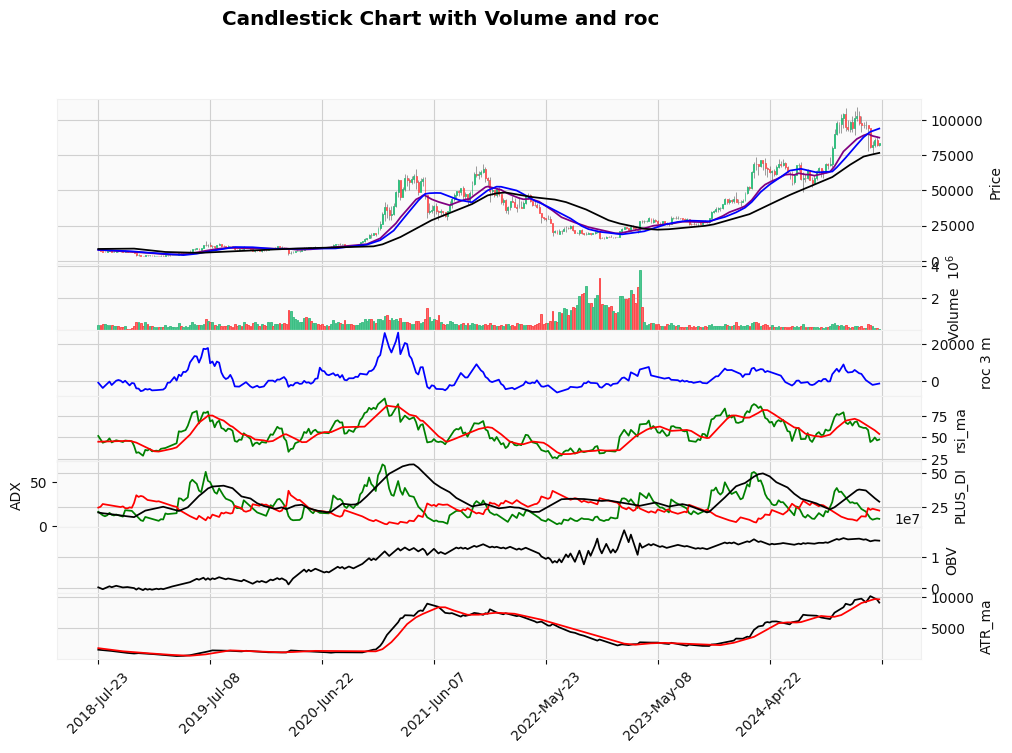

In [97]:
df_btc = data['BTCUSDT']

df_btc['ema'] = ta.EMA(df_btc['close'], timeperiod=21)
df_btc['sma'] = ta.SMA(df_btc['close'], timeperiod=21)
df_btc['sma_slow'] = ta.SMA(df_btc['close'], timeperiod=50)

# Calculate roc (Rate of Change)
# Multiply by 100 to express it as a percentage
df_btc['roc'] = ta.ROC(df_btc['close'], timeperiod=14) * 100
df_btc['rsi'] = ta.RSI(df_btc['close'], timeperiod=14)
df_btc['rsi_ma'] = ta.SMA(df_btc['rsi'], timeperiod=10)

df_btc['high_prev'] = df['high'].shift(12)
df_btc['dip'] = (df['low'] - df['high_prev']) / df['high_prev'] * 100
df_btc['dip_rolling'] = df_btc['dip'].rolling(14).mean()

# percentile_10 = df_btc['dip'].dropna().quantile(0.2)
# df_btc['Markers'] = df_btc['dip'] <= percentile_10
# marker_locations = df_btc['Markers'].astype(int)

df_btc['plus_di'] = ta.PLUS_DI(df_btc['high'], df_btc['low'], df_btc['close'], timeperiod=14)
df_btc['minus_di'] = ta.MINUS_DI(df_btc['high'], df_btc['low'], df_btc['close'], timeperiod=14)
df_btc['adx'] = ta.ADX(df_btc['high'], df_btc['low'], df_btc['close'], timeperiod=14)

df_btc['obv'] =ta.OBV(df_btc['close'], df_btc['volume'])

df_btc['atr'] = ta.ATR(df_btc['high'], df_btc['low'], df_btc['close'], timeperiod=14)
df_btc['atr_ma'] = ta.SMA(df_btc['atr'], timeperiod=10)

df_btc.dropna(inplace=True)

# Prepare additional plots for roc
add_plots = [
    # mpf.make_addplot(marker_locations, type='scatter', color='green', marker='.', markersize=1, panel=0),
    mpf.make_addplot(df_btc['ema'], panel=0, ylabel='Ema', color='purple'),
    mpf.make_addplot(df_btc['sma'], panel=0, ylabel='Sma', color='blue'),
    mpf.make_addplot(df_btc['sma_slow'], panel=0, ylabel='Sma', color='black'),
    

    mpf.make_addplot(df_btc['roc'], panel=2,
                     ylabel='roc 3 m', color='blue'),

    mpf.make_addplot(df_btc['rsi'], panel=3, ylabel='rsi', color='green'),
    mpf.make_addplot(df_btc['rsi_ma'], panel=3, ylabel='rsi_ma', color='red'),

    # mpf.make_addplot(df_btc['dip'], panel=4, ylabel='Dip', color='blue'),
    # mpf.make_addplot(df_btc['dip_rolling'], panel=4,
    #                  ylabel='Dip Rolling', color='red'),
    
    mpf.make_addplot(df_btc['plus_di'], panel=4
                     , ylabel='PLUS_DI', color='green'),
    
    mpf.make_addplot(df_btc['minus_di'], panel=4, ylabel='MINUS_DI', color='red'),
    
    mpf.make_addplot(df_btc['adx'], panel=4, ylabel='ADX', color='black'),
    
    mpf.make_addplot(df_btc['obv'], panel=5, ylabel='OBV', color='black'),
    
    mpf.make_addplot(df_btc['atr'], panel=6, ylabel='ATR', color='black'),
    mpf.make_addplot(df_btc['atr_ma'], panel=6, ylabel='ATR_ma', color='red'),

]

# Plot candlestick chart with Volume and roc
mpf.plot(
    df_btc,
    type='candle',      # Candlestick chart
    volume=True,        # Include volume panel
    addplot=add_plots,  # Add plots
    title='Candlestick Chart with Volume and roc',
    style='yahoo',      # Chart style
    ylabel='Price',
    figsize=(12, 8)
)

## Analyses

For some strategies it might make sense to nalyse outliers of the indicators / metrics.

count    350.000000
mean      55.383047
std       14.850907
min       25.724409
25%       44.652179
50%       55.101207
75%       66.221798
max       94.828053
Name: rsi, dtype: float64
0.05th Percentile: 33.4157851397257
Count of occurrences below or equal to the 0.05th Percentile: 18


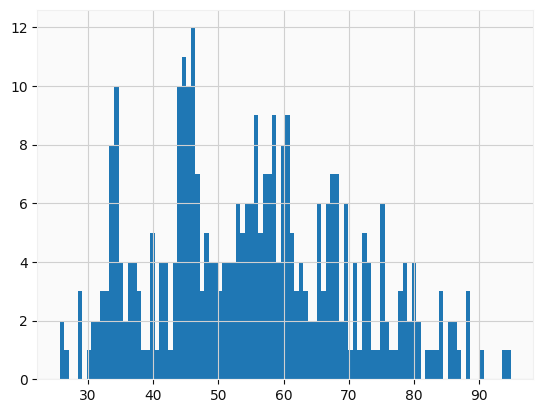

In [98]:
# change bins to 10
df_btc['rsi'].hist(bins=100)
print(df_btc['rsi'].describe())
X = 0.05
percentile_X = df_btc['rsi'].dropna().quantile(X)
print(f"{X}th Percentile: {percentile_X}")
count_below_percentile_10 = (df_btc['rsi'] <= percentile_X).sum()

print(f"Count of occurrences below or equal to the {X}th Percentile: {count_below_percentile_10}")

## Simple long strategy idea

Entry: PLUS_DI crosses above ADX and ADX is growing
Exit: ADX srops growing
Stop loss: 10%

In [99]:
# Prepare params
def params_long() -> dict:
    adx_p = np.arange(14, 42 + 2, step=1)
    plus_di_p = np.arange(14, 42 + 2, step=1)

    permutations = (
        1
        * len(adx_p)
        * len(plus_di_p)
    )

    print(f"Number of permutations params_long: {permutations}")
    return {
        "adx_p": adx_p,
        "plus_di_p": plus_di_p,
    }

In [100]:
## Prepare signal function

def signals_breakout_long(
    closes,
    highs,
    lows,
    opens,
    adx_p,
    plus_di_p,
):
    signal = np.full(closes.shape, np.nan)
    adx = ta.ADX(highs, lows, closes, timeperiod=adx_p)
    plus_di = ta.PLUS_DI(highs, lows, closes, timeperiod=plus_di_p)

    for idx in range(len(closes)):
        if idx < 1:
            signal[idx] = 0
            continue

        buy = (
            adx[idx] > adx[idx-1]
            and plus_di[idx] > adx[idx]
        )

        exit_buy = (
            adx[idx] < adx[idx-1]
        )

        if buy:
            signal[idx] = 1
        elif exit_buy:
            signal[idx] = -2
        else:
            signal[idx] = 0

    return signal

In [101]:
# Compute signals function
def compute_signals_long(args: tuple):
    symbol, ohlc_dict, params = args
    indicator = vbt.IndicatorFactory(
        class_name="Long",
        short_name="long",
        input_names=[
            "closes",
            "highs",
            "lows",
            "opens",
        ],
        param_names=[
            "adx_p",
            "plus_di_p",
        ],
        output_names=["value"]).from_apply_func(
        signals_breakout_long,
        adx_p=10,
        plus_di_p=10,
        to_2d=False
    )
    closes = ohlc_dict["closes"]
    highs = ohlc_dict["highs"]
    lows = ohlc_dict["lows"]
    opens = ohlc_dict["opens"]
    res = indicator.run(
        closes,
        highs,
        lows,
        opens,
        adx_p=params["adx_p"],
        plus_di_p=params["plus_di_p"],
        param_product=True
    )

    entries = res.value == 1
    exits = res.value == -2
    short_entries = res.value == -1
    short_exits = res.value == 2

    print(f"End computing signals for {symbol}")
    return symbol, entries, exits, short_entries, short_exits

In [102]:
params = params_long()
symbol, entries, exits, short_entries, short_exits = compute_signals_long((symbol, ohlc_dict[symbol], params))

Number of permutations params_long: 900
End computing signals for BTCUSDT


In [103]:

pf = vbt.Portfolio.from_signals(close=closes,
                                entries=entries,
                                exits=exits,
                                short_entries=short_entries,
                                short_exits=short_exits,
                                init_cash=1000,
                                fees=0.001,
                                sl_stop=0.1,  # 10% stop loss
                                open=opens,
                                high=highs,
                                low=lows,
                                direction='longonly',
                                )

In [104]:
pf.total_return()
figr = pf.total_return().vbt.heatmap(
    x_level='long_adx_p', y_level='long_plus_di_p', symmetric=False,
    trace_kwargs=dict(colorbar=dict(title='Total return', tickformat='%')))
figr.show()

In [ ]:
total_return = pf.total_return().to_frame()
win_rate = pf.trades.win_rate().to_frame()
trade_count = pf.trades.count().to_frame()
profit_factor = pf.trades.profit_factor().to_frame()
# max_drawdown = pf.max_drawdown().to_frame()
expectancy = pf.trades.expectancy().to_frame()
# merge total_return and win_rate
merged = pd.concat(
    [total_return,
     win_rate,
     trade_count,
     profit_factor,
     ],
    axis=1)
# df_e = merged.sort_values(by='expectancy', ascending=False).head(5)
# print(df_e.head(5))

df_pf = merged.sort_values(by='profit_factor', ascending=False).head(5)
print(df_pf.head(5))

df_wr = merged.sort_values(by='win_rate', ascending=False).head(5)
print(df_wr.head(5))

                           total_return  win_rate  count  profit_factor
long_adx_p long_plus_di_p                                              
38         16                 17.134729  0.818182     11      25.773508
           14                 15.660033  0.800000     10      23.641382
           15                 15.660033  0.800000     10      23.641382
42         14                 11.261438  0.800000     10      17.296057
38         20                 17.323602  0.750000     12      13.445843
                           total_return  win_rate  count  profit_factor
long_adx_p long_plus_di_p                                              
38         16                 17.134729  0.818182     11      25.773508
           14                 15.660033  0.800000     10      23.641382
           15                 15.660033  0.800000     10      23.641382
42         14                 11.261438  0.800000     10      17.296057
38         17                 15.288646  0.750000     12      12

In [110]:
pf[(38, 16)].stats()

Start                         2017-08-14 00:00:00+00:00
End                           2025-03-31 00:00:00+00:00
Period                               2793 days 00:00:00
Start Value                                      1000.0
End Value                                  18134.728731
Total Return [%]                            1713.472873
Benchmark Return [%]                        1939.955559
Max Gross Exposure [%]                            100.0
Total Fees Paid                              138.776048
Max Drawdown [%]                               41.63156
Max Drawdown Duration                 637 days 00:00:00
Total Trades                                         11
Total Closed Trades                                  11
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  81.818182
Best Trade [%]                               366.948096
Worst Trade [%]                                 

#########################
(np.int64(38), np.int64(16)) 81.82%


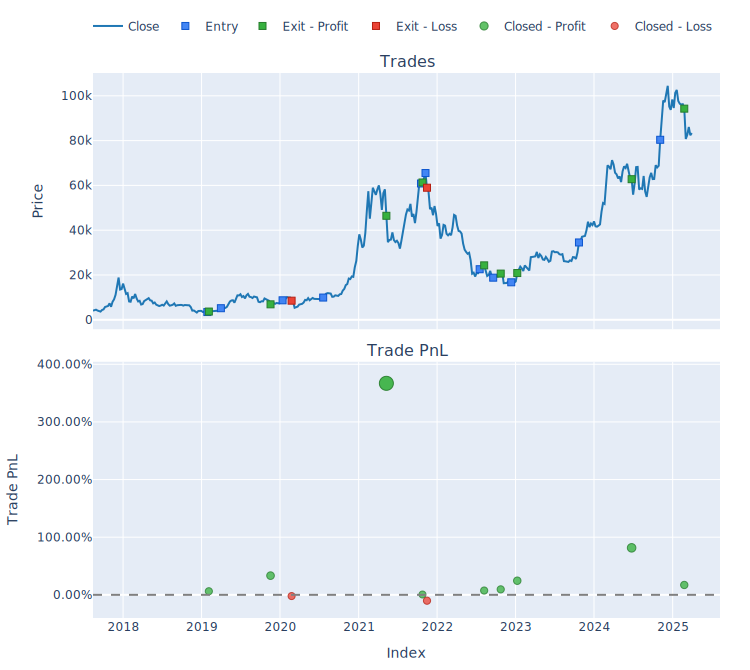

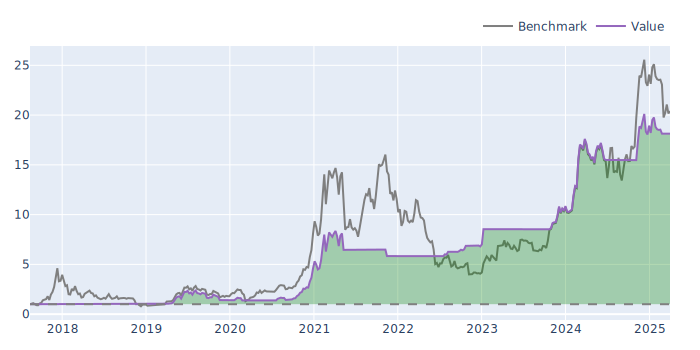

#########################


In [115]:
# get first row from df_pf
idx = 0
print("#########################")
win_rate = pf.trades[df_pf.index[idx]].win_rate()
print(symbol, f"{round(win_rate*100, 2)}%")
pf.trades[df_pf.index[idx]].plots(settings=dict(plot_zones=False)).show_svg()
pf[df_pf.index[idx]].plot_cum_returns().show_svg()
print("#########################")